In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data loading.....

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
import tensorflow as tf
import scipy.io as sio
from tensorflow.keras import layers
import os

from sklearn.model_selection import train_test_split




In [2]:
def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data("/kaggle/input/svhndataset/train_32x32.mat")
X_test, y_test = load_data("/kaggle/input/svhndataset/test_32x32.mat")

print("Training set", X_train.shape, y_train.shape)

Training set (32, 32, 3, 73257) (73257, 1)


In [3]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print('')

print("Test Set", X_test.shape)
print('')

Training Set (73257, 32, 32, 3)

Test Set (26032, 32, 32, 3)



In [52]:
X_train[0].shape

(32, 32, 3)

In [53]:
y_train[0]

1

In [4]:
# Normalize the images to a pixel value range of 0 to 1
#Rescaling
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten  # Importing CNN Module
from tensorflow.keras.utils import to_categorical

In [6]:
# One-hot encode the labels
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)



In [10]:
from sklearn.model_selection import train_test_split

# Split the training data into 80% training and 20% validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [57]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Data augmentation  on SVHN using Tansorflow

In [11]:
# Convert the splits into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))

# Define augmentation for training dataset
def augment_image(image, label):
    image = tf.image.resize(image, (64, 64))  
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label


# Create the augmented training dataset
augmented_train_dataset = train_dataset.map(augment_image)
augmented_train_dataset = augmented_train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create and prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset = val_dataset.map(augment_image).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Check shapes
for images, labels in augmented_train_dataset.take(1):
    print(f"Augmented Train Batch shape: {images.shape}, Labels shape: {labels.shape}")

for images, labels in val_dataset.take(1):
    print(f"Validation Batch shape: {images.shape}, Labels shape: {labels.shape}")

Augmented Train Batch shape: (32, 64, 64, 3), Labels shape: (32, 10)
Validation Batch shape: (32, 64, 64, 3), Labels shape: (32, 10)


# Step_2: Dataset Training

In [12]:
# Updated model architecture
model = models.Sequential([
    layers.InputLayer(input_shape=(64, 64, 3)),  # Set input shape to 64x64

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Output shape will be (32, 32, 32)

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Output shape will be (16, 16, 64)

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  # Output shape will be (8, 8, 128)

    # Flatten and Dense layers
    layers.Flatten(),  # Flattening will yield 8192 inputs
    layers.Dense(128, activation='relu'),  # 128 neurons in this layer
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(augmented_train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 207s 112ms/step - accuracy: 0.3647 - loss: 1.8012 - val_accuracy: 0.7811 - val_loss: 0.7136
Epoch 2/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 204s 111ms/step - accuracy: 0.7947 - loss: 0.6816 - val_accuracy: 0.8280 - val_loss: 0.5665
Epoch 3/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 205s 112ms/step - accuracy: 0.8374 - loss: 0.5374 - val_accuracy: 0.8434 - val_loss: 0.5220
Epoch 4/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 262s 112ms/step - accuracy: 0.8609 - loss: 0.4613 - val_accuracy: 0.8544 - val_loss: 0.4829
Epoch 5/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 205s 112ms/step - accuracy: 0.8746 - loss: 0.4157 - val_accuracy: 0.8633 - val_loss: 0.4505
Epoch 6/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 207s 113ms/step - accuracy: 0.8857 - loss: 0.3809 - val_accuracy: 0.8662 - val_loss: 0.4477
Epoch 7/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 208s 114ms/step - accuracy: 0.8949 - loss: 0.3528 - val_accuracy: 0.8669 - val_loss: 0.4504
Epoch 8/10
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 206s 112ms/step - ac

In [18]:
# PLot the validation and training curvees seperately
def plot_loss_curves(history):
  """
  Returns seperate Loss curves for training and validation metrics
  """
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # PLot Loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # PLot accuracy
  plt.figure() # Create a new figure
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

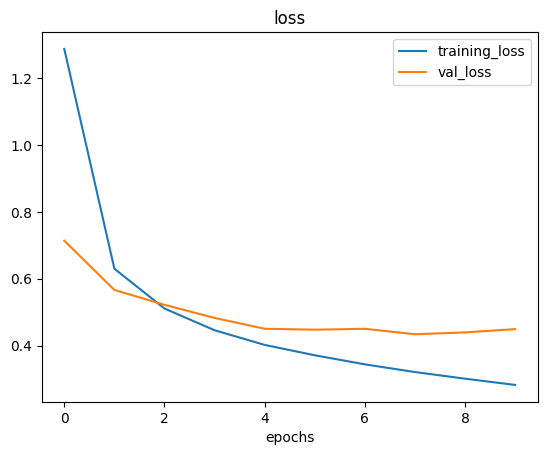

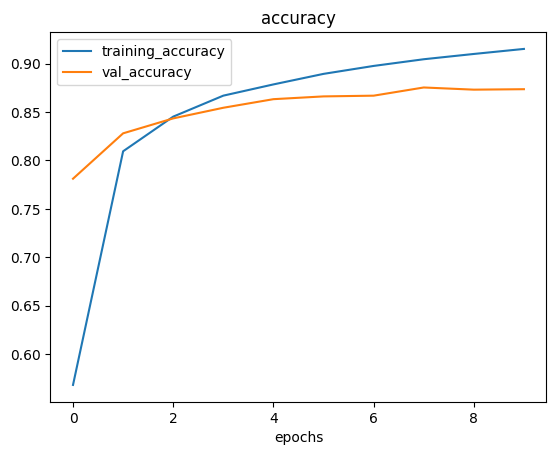

In [20]:
plot_loss_curves(history)

**TESTING**

In [30]:
print(X_test.shape)
print(y_test.shape)

def resize_images(image, label):
    image = tf.image.resize(image, [64, 64])
    return image, label

# Apply resizing to the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(resize_images)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Evaluate the model on the resized test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

(26032, 32, 32, 3)
(26032, 10)
814/814 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8546 - loss: 0.5267
Test accuracy: 0.8546404242515564
Test Loss: 0.5237672328948975


**Confusion matrix**

814/814 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step


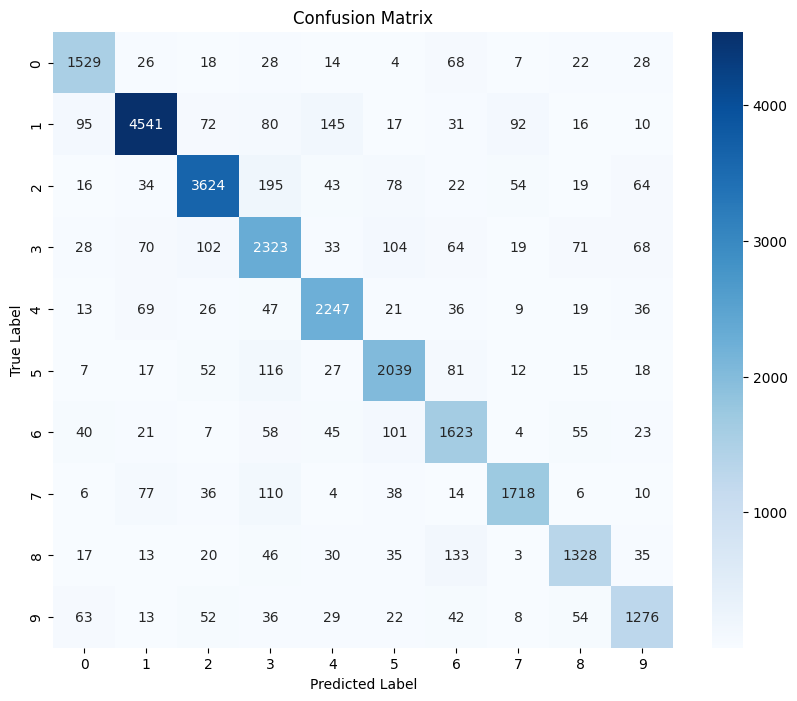

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Make predictions on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels

# 2. Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()